### 2.1) Transition disk SED with radmc3dPy

<img src="data/dm_tau_sed.png" alt="Drawing" style="width: 600px;"/>

#### DM Tauri

Well characterizes transition disk (e.g. McClure et al. 2016):

<table>
    <tr>
        <td>M$_{\star}$</td>
        <td>0.65 M$_{\odot}$</td>
    </tr>
    <tr>
        <td>T$_{\star}$</td>
        <td>3720 K</td>
    </tr>
    <tr>
        <td>R$_{\star}$</td>
        <td>1.2 R$_{\odot}$</td>
    </tr>
    <tr>
        <td>M$_{disk}$</td>
        <td>0.05 -- 0.066 M$_{\odot}$</td>
    </tr>
    <tr>
        <td>R$_{in}$</td>
        <td>3 -- 4 M$_{\odot}$</td>
    </tr>
    <tr>
        <td>R$_{disk}$</td>
        <td>800 au</td>
    </tr>
    <tr>
        <td>$i$</td>
        <td>35 deg</td>
    </tr>
</table>

#### Parametric disk model

The analytical prescription of a generic protoplanetary disk is given by 
its pressure scale height, $H(r)$, and surface density, $\Sigma(r)$, profiles (as functions of 
distance from the central proto-star).

$H(r)$ is described by $H_0$ normalisation, the location $r_\mathrm{pivot}$, where $H_0$ is given and the power exponent of its radial dependence, which is asumed to be 1./7. in this case.
The surface density profile is described similarly by $\Sigma_0$, $r_\mathrm{sig}$ and plsig1. Tipically $r_\mathrm{pivot} = r_\mathrm{sig} = 1$ au or $r_\mathrm{disk}$.

$H(r) = H_0\, \times\, ({r\, / \, r_\mathrm{pivot}})^{1/7}$

$\Sigma(r) = \Sigma_0 \times ({r \, / \, r_\mathrm{sig}})^{plsig1}$

$\rho(r,z) = {\Sigma(r) \over { H(r) \sqrt{2\pi} } } \exp[{-{1 \over 2} ({z\, /\, H(r)})^{2}}]$

#### Create working directory and the parameter file:

In [1]:
# Import radmc3dPy library
import radmc3dPy
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as c
from astropy.io import ascii
# Import additional functions created for the tutorial
import tutorial_functions

%matplotlib inline

main_dir = os.getcwd()      # directory of the tutorial
work_dir = '/dm_tau_model'   # working directory for the DM Tau model

# Check if directory exists
if not os.path.isdir(main_dir+work_dir): 
    os.mkdir(main_dir+work_dir)
os.chdir(main_dir+work_dir)

In [2]:
%%file problem_params.inp
# radmc3dPy parameter file
#-----------------------------------------------------------
# Block: Stellar Parameters
#-----------------------------------------------------------
mstar                     = [0.65*ms]  # Mass of the star(s)
pstar                     = [0.0, 0.0, 0.0]  # Position of the star(s) (cartesian coordinates)
rstar                     = [1.2*rs]  # Radius of the star(s)
tstar                     = [3720.0]  # Effective temperature of the star(s) [K]
#-----------------------------------------------------------
# Block: Spatial grid parameters
#-----------------------------------------------------------
crd_sys                   = 'sph'     # Coordinate system used (car/cyl)
xbound                    = [0.1*au,1.0*au,1000.0*au]  # Boundaries for the x grid
nx                        = [40,100]  # Number of grid points in the first dimension
ybound                    = [0.,pi/2.]   # Boundaries for the y grid
ny                        = 80        # Number of grid points in the second dimension
zbound                    = [0., 2.0*pi]  # Boundaries for the z grid
nz                        = 0         # Number of grid points in the third dimension
#-----------------------------------------------------------
# Block: Wavelength grid parameters
#-----------------------------------------------------------
nw                        = [20, 20, 20]    # Number of points in the wavelength grid
wbound                    = [0.1, 7.0, 25.0, 1e4]  # Boundaries for the wavelength grid
#-----------------------------------------------------------
# Block: Dust opacity
#-----------------------------------------------------------
dustkappa_ext             = ['silicate']  # opacity name, optional values: silicate, silicate_1micron, silicate_1mm
ngs                       = 1  # Number of grain sizes
#-----------------------------------------------------------
# Block: Code parameters
#-----------------------------------------------------------
istar_sphere              = 1  # 1 - take into account the finite size of the star, 0 - take the star to be point-like
nphot                     = long(1e6)  # Nr of photons for the thermal Monte Carlo
nphot_scat                = long(1e5)  # Nr of photons for the scattering Monte Carlo (for images)
nphot_spec                = long(1e5)  # Nr of photons for the scattering Monte Carlo (for spectra)
rto_style                 = 1  # Format of output files (1-ascii, 2-unformatted f77, 3-binary
scattering_mode_max       = 0  # 0 - no scattering, 1 - isotropic scattering, 2 - anisotropic scattering
tgas_eq_tdust             = 1  # Take the dust temperature to identical to the gas temperature
modified_random_walk      = 1  # Use the modified random walk method to improve speed?
#-----------------------------------------------------------
# Block: Disk parameters
#-----------------------------------------------------------
bgdens                    = 1e-30    # Background density (g/cm^3)
dusttogas                 = 0.01     # Dust-to-gas mass ratio
hrdisk                    = 0.07      # Ratio of the pressure scale height over radius at hrpivot
hrpivot                   = 100.*au  # Reference radius at which Hp/R is taken
mdisk                     = 0.05*ms  # Mass of the disk
plh                       = 1.0/7.0  # Flaring index
rsig                      = 100.0*au  # Radius at which the surface density normalisation (sig0) is given
plsig1                    = -1.5     # Power exponent of the surface density distribution as a function of radius
plsig2                    = -12.0    # Power law exponent at r > rdisk (abrubt cutoff at rdisk is not realistic)
rdisk                     = 800.0*au  # Outer radius of the disk
rin                       = 3.0*au   # Inner radius of the disk

Overwriting problem_params.inp


#### Create spatial and wavelength grids:

In [3]:
# read the parameters from the problem_params.inp file 
modpar = radmc3dPy.analyze.readParams()

# make a local copy of the ppar dictionary
ppar = modpar.ppar

# create the radmc3dGrid object:
grid = radmc3dPy.analyze.radmc3dGrid()

# create the wavelength grid
grid.makeWavelengthGrid(ppar=ppar)

# create the spatial grid
grid.makeSpatialGrid(ppar=ppar)

# create radiation source
radSources = radmc3dPy.analyze.radmc3dRadSources(ppar=ppar, grid=grid)
radSources.getStarSpectrum(tstar=ppar['tstar'], rstar=ppar['rstar'])

#### Dust density distribution

In [4]:
# Create a radmc3dData object, this will contain the density
data = radmc3dPy.analyze.radmc3dData(grid)

# get the spherical coordinates and convert them to cylindrical
rr, th = np.meshgrid(grid.x, grid.y)
z0 = np.zeros([grid.nx, grid.nz, grid.ny], dtype=np.float64)
zz   = rr * np.cos(th)
rcyl = rr * np.sin(th)

# parametric pressure scale height
hp = np.zeros([grid.nx, grid.ny, grid.nz], dtype=np.float64)
dum = ppar['hrdisk'] * (rcyl/ppar['hrpivot'])**ppar['plh'] * rcyl
dum = dum.swapaxes(0,1)
for iz in range(grid.nz):  # copy the (x,y) grid to each z coordinates
    hp[:,:,iz] = dum
       
# sig0 is 1 and we calculate the surface density profile:
sigma = np.zeros([grid.nx, grid.ny, grid.nz], dtype=np.float64)

dum1 = 1.0 * (rcyl/ppar['rsig'])**ppar['plsig1']

# Clear out within rdisk and cut-off at rout
for iy in range(grid.ny):
    ii = (rcyl[iy,:]>ppar['rdisk'])
    jj = (rcyl[iy,:]<ppar['rin'])
    sig0_tmp = 1.0 * (ppar['rdisk']/ppar['rsig'])**ppar['plsig1']
    dum1[iy,ii] = sig0_tmp * (rcyl[iy,ii]/ppar['rdisk'])**ppar['plsig2']
    dum1[iy,jj] = 0.0

dum1 = dum1.swapaxes(0,1)
for iz in range(grid.nz):  # copy the (x,y) grid to each z coordinates
    sigma[:,:,iz] = dum1

# We calculate the disk density using the above surface density profile:
rho_disk_tot  = np.zeros([grid.nx, grid.ny, grid.nz,1], dtype=np.float64)
for iz in range(grid.nz):
    for iy in range(grid.ny):
        rho_disk_tot[:,iy,iz,0] = sigma[:,iy,iz] /        \
            (hp[:,iy,iz] * np.sqrt(2.0*np.pi)) *          \
            np.exp(-0.5 * ((zz[iy,:])-z0[:,iz,iy]) *      \
            ((zz[iy,:])-z0[:,iz,iy]) /                    \
             (hp[:,iy,iz]*hp[:,iy,iz]))
                    
# Calculate the volume of each grid cell
vol  = grid.getCellVolume()

# Now we calculate the mass in rho_disk_tot and scale the density to get back the
# desired disk mass (['mdisk'] parameter) *only if ['mdisk'] is set*:
mass = (rho_disk_tot[:,:,:,0]*vol).sum(0).sum(0).sum(0)
rho_disk_tot = rho_disk_tot * (ppar['mdisk']*0.5/mass) 
# Note that: * 0.5 -> we only consider the upper half of the disk

# 2) Now calculate the dust density by scaling the disk mass with the dust/gas ratio:
rho_disk_dust = rho_disk_tot * ppar['dusttogas']

# Background density
rho_bg = np.zeros([grid.nx, grid.ny, grid.nz, 1], dtype=np.float64) + (ppar['bgdens'] * ppar['dusttogas'])

data.rhodust =rho_disk_dust + rho_bg

#### Write RADMC-3D inputs

In [5]:
#Frequency grid
grid.writeWavelengthGrid(old=False)

#Spatial grid
grid.writeSpatialGrid(old=False)

#Input radiation field
radSources.writeStarsinp(ppar=ppar, old=False)

#Dust density distribution
data.writeDustDens(binary=False, old=False)

#radmc3d.inp
radmc3dPy.setup.writeRadmc3dInp(modpar=modpar)

#Master dust opacity file
opac=radmc3dPy.analyze.radmc3dDustOpac()
opac.writeMasterOpac(ext=ppar['dustkappa_ext'], 
                     scattering_mode_max=ppar['scattering_mode_max'], old=False)

# Copy the dust opacity file
shutil.copy(main_dir+'/data/'+'dustkappa_'+ppar['dustkappa_ext'][0]+'.inp','.')

Writing wavelength_micron.inp
Writing amr_grid.inp
Writing stars.inp
Writing dust_density.inp
Writing radmc3d.inp
Writing dustopac.inp


In [6]:
# Run the thermal Monte Carlo radiative transfer
!radmc3d mctherm setthreads 4

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
        This is the 3-D reincarnation of the 2-D RADMC code      
                (c) 2010/2015 Cornelis Dullemond                 
                                                                 
 ************* NOTE: THIS IS STILL A BETA VERSION ***************
 ****** Some modes/capabilities are not yet ready/mature ********
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
      the RADMC-3D mailing list by sending an email to me:       
                    dullemond@uni-heidelberg.de                  
       

 Thread:           0 Photon nr:      111000
 Thread:           3 Photon nr:      112000
 Thread:           1 Photon nr:      113000
 Thread:           1 Photon nr:      114000
 Thread:           1 Photon nr:      115000
 Thread:           2 Photon nr:      116000
 Thread:           1 Photon nr:      117000
 Thread:           2 Photon nr:      118000
 Thread:           3 Photon nr:      119000
 Thread:           0 Photon nr:      120000
 Thread:           1 Photon nr:      121000
 Thread:           3 Photon nr:      122000
 Thread:           2 Photon nr:      123000
 Thread:           2 Photon nr:      124000
 Thread:           0 Photon nr:      125000
 Thread:           0 Photon nr:      126000
 Thread:           1 Photon nr:      127000
 Thread:           1 Photon nr:      128000
 Thread:           2 Photon nr:      129000
 Thread:           3 Photon nr:      130000
 Thread:           0 Photon nr:      131000
 Thread:           0 Photon nr:      132000
 Thread:           2 Photon nr: 

 Thread:           2 Photon nr:      298000
 Thread:           1 Photon nr:      299000
 Thread:           0 Photon nr:      300000
 Thread:           3 Photon nr:      301000
 Thread:           2 Photon nr:      302000
 Thread:           1 Photon nr:      303000
 Thread:           2 Photon nr:      304000
 Thread:           0 Photon nr:      305000
 Thread:           0 Photon nr:      306000
 Thread:           2 Photon nr:      307000
 Thread:           0 Photon nr:      308000
 Thread:           0 Photon nr:      309000
 Thread:           1 Photon nr:      310000
 Thread:           0 Photon nr:      311000
 Thread:           3 Photon nr:      312000
 Thread:           0 Photon nr:      313000
 Thread:           3 Photon nr:      314000
 Thread:           3 Photon nr:      315000
 Thread:           3 Photon nr:      316000
 Thread:           2 Photon nr:      317000
 Thread:           1 Photon nr:      318000
 Thread:           2 Photon nr:      319000
 Thread:           2 Photon nr: 

 Thread:           3 Photon nr:      485000
 Thread:           3 Photon nr:      486000
 Thread:           2 Photon nr:      487000
 Thread:           1 Photon nr:      488000
 Thread:           2 Photon nr:      489000
 Thread:           3 Photon nr:      490000
 Thread:           1 Photon nr:      491000
 Thread:           1 Photon nr:      492000
 Thread:           0 Photon nr:      493000
 Thread:           3 Photon nr:      494000
 Thread:           3 Photon nr:      495000
 Thread:           3 Photon nr:      496000
 Thread:           2 Photon nr:      497000
 Thread:           0 Photon nr:      498000
 Thread:           2 Photon nr:      499000
 Thread:           3 Photon nr:      500000
 Thread:           2 Photon nr:      501000
 Thread:           0 Photon nr:      502000
 Thread:           2 Photon nr:      503000
 Thread:           1 Photon nr:      504000
 Thread:           1 Photon nr:      505000
 Thread:           1 Photon nr:      506000
 Thread:           2 Photon nr: 

 Thread:           2 Photon nr:      672000
 Thread:           0 Photon nr:      673000
 Thread:           2 Photon nr:      674000
 Thread:           2 Photon nr:      675000
 Thread:           0 Photon nr:      676000
 Thread:           1 Photon nr:      677000
 Thread:           1 Photon nr:      678000
 Thread:           0 Photon nr:      679000
 Thread:           1 Photon nr:      680000
 Thread:           1 Photon nr:      681000
 Thread:           1 Photon nr:      682000
 Thread:           3 Photon nr:      683000
 Thread:           0 Photon nr:      684000
 Thread:           1 Photon nr:      685000
 Thread:           1 Photon nr:      686000
 Thread:           2 Photon nr:      687000
 Thread:           2 Photon nr:      688000
 Thread:           1 Photon nr:      689000
 Thread:           0 Photon nr:      690000
 Thread:           1 Photon nr:      691000
 Thread:           3 Photon nr:      692000
 Thread:           1 Photon nr:      693000
 Thread:           2 Photon nr: 

 Thread:           2 Photon nr:      861000
 Thread:           1 Photon nr:      862000
 Thread:           2 Photon nr:      863000
 Thread:           1 Photon nr:      864000
 Thread:           2 Photon nr:      865000
 Thread:           3 Photon nr:      866000
 Thread:           1 Photon nr:      867000
 Thread:           1 Photon nr:      868000
 Thread:           0 Photon nr:      869000
 Thread:           2 Photon nr:      870000
 Thread:           3 Photon nr:      871000
 Thread:           3 Photon nr:      872000
 Thread:           3 Photon nr:      873000
 Thread:           2 Photon nr:      874000
 Thread:           3 Photon nr:      875000
 Thread:           1 Photon nr:      876000
 Thread:           2 Photon nr:      877000
 Thread:           2 Photon nr:      878000
 Thread:           0 Photon nr:      879000
 Thread:           2 Photon nr:      880000
 Thread:           2 Photon nr:      881000
 Thread:           1 Photon nr:      882000
 Thread:           3 Photon nr: 

Reading dust density
Reading dust temperature


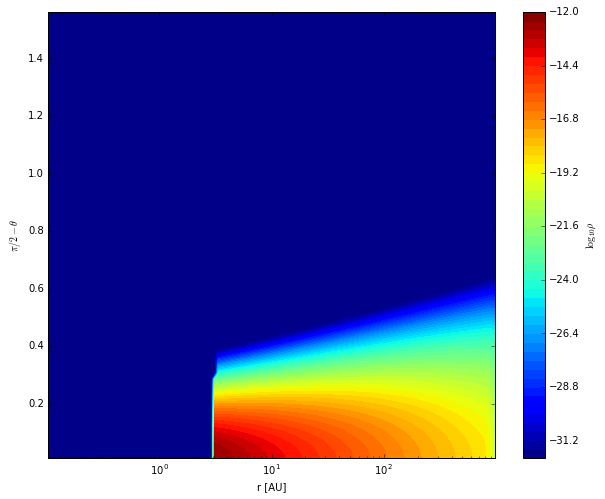

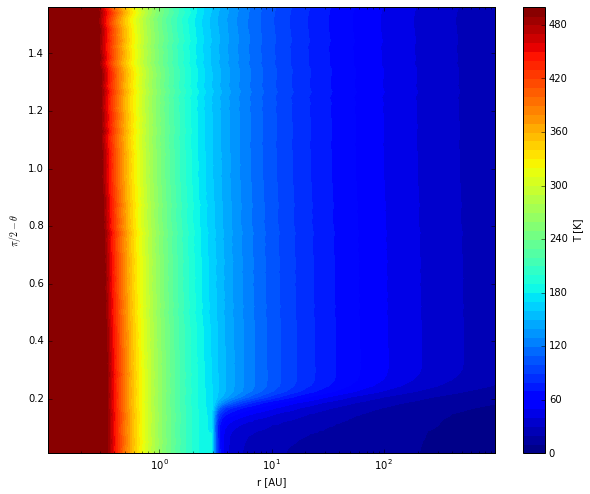

In [7]:

model = radmc3dPy.analyze.readData(dtemp=True,ddens=True,binary=False)

tutorial_functions.plotmodels(model,Tmax=500.,xlog=True)

#### Create an SED and compare it to the observations 

By default RADMC-3D includes both dust and line emission if the line data is available. To swhitch this off, we give the *noline* parameter:

In [8]:
# Calculate the SED
!radmc3d sed incl 35 noline

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
        This is the 3-D reincarnation of the 2-D RADMC code      
                (c) 2010/2015 Cornelis Dullemond                 
                                                                 
 ************* NOTE: THIS IS STILL A BETA VERSION ***************
 ****** Some modes/capabilities are not yet ready/mature ********
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
      the RADMC-3D mailing list by sending an email to me:       
                    dullemond@uni-heidelberg.de                  
       

In [9]:
### Read the observational data and the disk model
dmtau_phot = ascii.read(main_dir+'/data/dm_tau_phot.csv')
dmtau_irs = ascii.read(main_dir+'/data/dm_tau_irs.csv')

**Using small silicate grains**

[0.1, 10000.0, 1e-13, 1e-09]

/usr/lib/python2.7/dist-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


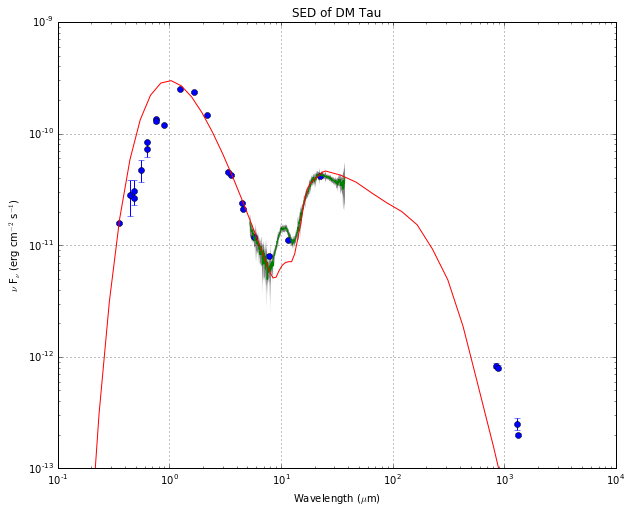

In [10]:
plt.figure(figsize=(10,8))
# Plot the data...
tutorial_functions.plot_obs_sed(dmtau_phot,dmtau_irs)
# ... and the disk model
tutorial_functions.plot_model_sed(fname='spectrum.out',dpc=140)

plt.axis([1e-1,1e4,1e-13,1e-9])

### Using different grain models


You have to modify the *dustkappa_ext* parameter in the problem_params.inp file to use different opacity model. (see the options above, where problem_params.inp is written)

The data folder in the repository root directory contains three silicate models:

* small grains
* grain size distribution with $a_\textrm{max} = 1\,\mu$m
* grain size distribution with $a_\textrm{max} = 1\,$mm

The models with size distributions assume $n(a) \propto a^{-3.5}$ and $a_\mathrm{min} = 0.1\,\mu$m.

**Try out how the SED changes with larger grains!**

### 2.2) Keplerian disk and CO line profile

We assume that in the gas velocity has only a $\phi$ component, it's value is given by the keplerian velocity:

$v_{\phi} = \sqrt{G M_{\star} / r_{cyl}}$

The following additional data is needed:

- Abundance of CO molecules
- Gas velocity
- Energy levels and transition frequencies, Einstein A coefficient
- Gas temperature (e.g. Tgas == Tdust assumption, this is set in radmc3d.inp!)
- Abundance of collisional partner and their collision rate (if non-LTE model)

Database for atomic and molecular excitation data: http://home.strw.leidenuniv.nl/~moldata/

In [11]:
def kepler_velocity(rcyl, mstar):

    Vkepler = np.sqrt( (c.G * (mstar * u.gram).to(u.kilogram) \
                     / (rcyl * u.centimeter).to(u.meter) ) ).to(u.centimeter/u.second).value

    return Vkepler

# Write velocities
#
fout = open(main_dir+work_dir+'/gas_velocity.inp','w')
fout.write('{:8n}\n'.format(1))                      # Format number
fout.write('{:8n}\n'.format(grid.nz*grid.ny*grid.nx))         # Nr of cells
for ip in range(grid.nz):
    for it in range(grid.ny):
        for ir in range(grid.nx):
            vtmp = kepler_velocity(rcyl[it,ir],ppar['mstar'])[0]
            fout.write('{:11.4E} {:11.4E} {:11.4E}\n'.format(0.0, 0.0, vtmp))

            
# Determine the CO number density
abCO = 1.4e-4

nCO = rho_disk_tot / (1.4 * c.m_p.value) * abCO

# Write CO number density
#
fout = open(main_dir+work_dir+'/numberdens_co.inp','w')
fout.write('{:8n}\n'.format(1))                               # Format number
fout.write('{:8n}\n'.format(grid.nz*grid.ny*grid.nx))         # Nr of cells
for ip in range(grid.nz):
    for it in range(grid.ny):
        for ir in range(grid.nx):
            fout.write('{:11.4E}\n'.format(nCO[ir,it,ip,0]))
fout.close()

In [12]:
%%file lines.inp
2
1
co leiden 0  0  0

Writing lines.inp


In [13]:
# Copy the dust opacity file
shutil.copy(main_dir+'/data/molecule_co.inp','.')

### Line emission map

**Single map at a given velocity channel/wavelength**:

* **iline**:      transition in the molecule_co.inp file, e.g. 1 refers to the (1-0) transition
* **vkms**:       velocity shift compared to the rest at which the image is calculated
* **npix**:       number of pixels in x and y directions
* **sizeau**:     area included in the image, i.e. the image is sizeau * sizeau area. The code also recognises the sizepc option
* **incl**:       disk inclination

Note that we do not include freeze-out of CO in this simple model!

In [14]:
!radmc3d image iline 1 vkms 0.5 npix 200 sizeau 2000 incl 35

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
        This is the 3-D reincarnation of the 2-D RADMC code      
                (c) 2010/2015 Cornelis Dullemond                 
                                                                 
 ************* NOTE: THIS IS STILL A BETA VERSION ***************
 ****** Some modes/capabilities are not yet ready/mature ********
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
      the RADMC-3D mailing list by sending an email to me:       
                    dullemond@uni-heidelberg.de                  
       

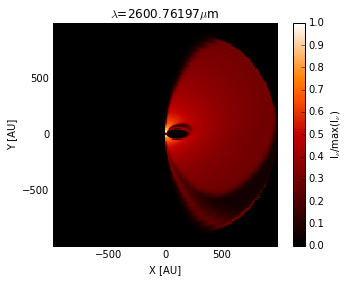

{'cbar': <matplotlib.colorbar.Colorbar at 0x7f44bd8bd2d0>,
 'implot': <matplotlib.image.AxesImage at 0x7f44bd1e0d90>}

In [15]:
channal_map = radmc3dPy.image.readImage(fname='image.out')

radmc3dPy.image.plotImage(channal_map, au=True, dpc=140., cmap=plt.cm.gist_heat)

**Map with multiple velocity channels/wavelengths**:

* **widthkms**:   emission maps are produced within this velocity range around the rest wavelength
* **linenlam**:   number of velocity channels

In [16]:
!radmc3d image iline 1 widthkms 2 npix 200 sizeau 2000 incl 35 linenlam 100

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
        This is the 3-D reincarnation of the 2-D RADMC code      
                (c) 2010/2015 Cornelis Dullemond                 
                                                                 
 ************* NOTE: THIS IS STILL A BETA VERSION ***************
 ****** Some modes/capabilities are not yet ready/mature ********
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
      the RADMC-3D mailing list by sending an email to me:       
                    dullemond@uni-heidelberg.de                  
       

In [17]:
channal_map = radmc3dPy.image.readImage(fname='image.out')

# Write fits image
channal_map.writeFits(fname='co_10.fits')

**Open the fits image**

> ds9 co_10.fits

Use the slider to switch between channels


### Calculate and plot the line spectrum

Note that we use the spectrum argument instead of the image here.

* **nodust**:   do not include the dust component in the raytracing. Note that at submm wavelength and narrow velocity ranges dust does not affect the spectra significantly.

In [18]:
#!radmc3d spectrum iline 1 incl 35 nodust widthkms 2.5 linenlam 100

# To see a more pronouced specra shape increase the inclination:
!radmc3d spectrum iline 1 incl 80 nodust widthkms 2.5 linenlam 100

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
        This is the 3-D reincarnation of the 2-D RADMC code      
                (c) 2010/2015 Cornelis Dullemond                 
                                                                 
 ************* NOTE: THIS IS STILL A BETA VERSION ***************
 ****** Some modes/capabilities are not yet ready/mature ********
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
      the RADMC-3D mailing list by sending an email to me:       
                    dullemond@uni-heidelberg.de                  
       

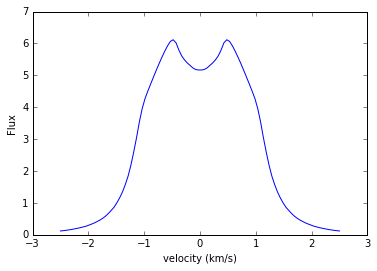

In [19]:
# Units
ccgs = 2.99792458e10            # cm/s
cmicron = 2.99792458e14         # micron/s
lam0 = 2600.7576334647010       # wavelength of CO (1-0) transition
Jy = 1e-23                      # Jy in erg/s/cm^2/Hz

dpc = 140.                      # Distance to the object in pc

spec = radmc3dPy.analyze.readSpectrum()
lam = spec[:,0]
flux = spec[:,1] / Jy / dpc**2  # Convert to Jy and scale with distancec

# Calculate velocity
nu = cmicron / lam
nu0 = cmicron / lam0
# radio definition
v = ccgs * (1-(nu/nu0)) / 1e5    # km/s

# Plot spectra
plt.plot(v, flux)
plt.xlabel('velocity (km/s)')
plt.ylabel('Flux')